#  Catalogs Matching

---
**License**

 Catalogs Matching

 Sat Jul 5 15:00:00 2025\
 Copyright  2025\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Henique Cardoso Naves Lettieri <henrique.cnl23@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---
 catalogs_matching\
 Copyright (C) 2025 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Henrique Cardoso Naves Lettieri <henrique.cnl23@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Libraries & Configs

In [1]:
from numcosmo_py import Nc, Ncm, sky_match
from numcosmo_py.helper import npa_to_seq
Ncm.cfg_init()

import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import SmoothBivariateSpline
from scipy.integrate import quad 

from astropy.io import fits
from astropy.table import Table, unique
import pandas as pd

from clevar.match import MembershipMatch, get_matched_pairs
import clevar
from clevar import ClCatalog

import sys
sys.path.insert(0, "/global/homes/l/lettieri/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "/global/homes/l/lettieri/gcr-catalogs")
sys.path.insert(0, "/global/homes/l/lettieri/")
sys.path.insert(0, "/global/homes/l/lettieri/NumCosmo/notebooks/richness_proxy/CatalogsMatching/")

from match_id import MatchID as MID

import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")
print('GCRCatalogs =', GCRCatalogs.__version__, '|' ,'GCR =', GCRCatalogs.GCR.__version__)

GCRCatalogs = 1.9.0 | GCR = 0.9.2


## Data

In [2]:
zmin = 0.0
zmax = 1.2
logMmin = 13.0
logMmax = 15.0
logRmin = 0
logRmax = 3 

#Cosmo DC2
cosmodc2= GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

#Cosmo DC2 + RedMaPPer
catalog_dc2_redmapper = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.8.1')

print("CosmoDC2 info:")
print(f"Version: {cosmodc2.get_catalog_info('version')}")
print(f"Sky area: {cosmodc2.get_catalog_info('sky_area')}")
print(f"Cosmology: {cosmodc2.get_catalog_info('cosmology')}")

data_dc2 = cosmodc2.get_quantities(
    ["halo_id" , "redshift_true", "halo_mass", "ra_true", "dec_true"],
    filters=[
        f"redshift_true > {zmin}",
        f"redshift_true < {zmax}",
        f"halo_mass > {10**logMmin}",
        f"halo_mass < {10**logMmax}",
        f"is_central == {True}", 
    ],
)

print("Redmapper info:")
print(f"Version: {catalog_dc2_redmapper.get_catalog_info('version')}")
print(f"Sky area: {catalog_dc2_redmapper.get_catalog_info('sky_area')}")
print(f"Cosmology: {catalog_dc2_redmapper.get_catalog_info('cosmology')}")

data_redmapper = catalog_dc2_redmapper.get_quantities(
    ["cluster_id", "redshift", "redshift_err", "richness", "richness_err", "ra", "dec"],
    filters=[
        f"redshift > {zmin}",
        f"redshift < {zmax}",
        f"richness > {10**logRmin}",
        f"richness < {10**logRmax}",
    ],
)

#Matched data
id_data = Table.read('/global/homes/l/lettieri/NumCosmo/notebooks/trend/match_id.fits')
proximity_data = Table.read('/global/homes/l/lettieri/NumCosmo/notebooks/trend/match_proximity.fits')

#Clevar matched data
halos_clevar = ClCatalog("clevar halos")
clusters_clevar = ClCatalog("clevar clusters")
mt = MembershipMatch()
mt.load_matches(clusters_clevar, halos_clevar, out_dir='cDC2_RM_match_cross_membership')

#Converting the cross matched indices from str to int  
for i in range(len(clusters_clevar['mt_cross'])):
    if clusters_clevar['mt_cross'][i] !=None:
        clusters_clevar['mt_cross'][i] = np.int64(clusters_clevar['mt_cross'][i])

for i in range(len(halos_clevar['mt_cross'])):
    if halos_clevar['mt_cross'][i] !=None:
        halos_clevar['mt_cross'][i] = np.int64(halos_clevar['mt_cross'][i])

CosmoDC2 info:
Version: 1.1.4
Sky area: 439.78987
Cosmology: {'H0': 71.0, 'Om0': 0.2648, 'Ob0': 0.0448, 'sigma8': 0.8, 'n_s': 0.963}
Redmapper info:
Version: None
Sky area: 439.78987
Cosmology: {'H0': 71.0, 'Om0': 0.2648, 'Ob0': 0.0448, 'sigma8': 0.8, 'n_s': 0.963}
clevar clusters
    * ClEvar used in matching: 0.17.1


/global/homes/l/lettieri/.local/lib/python3.13/site-packages/clevar-0.17.1-py3.13.egg/clevar/catalog/tagdata.py:308: UserWarning: id column missing, additional one is being created.
  warnings.warn(f"{id_name} column missing, additional one is being created.")


 * Total objects:    45,081
 * multiple (self):  43,106
 * multiple (other): 43,106
 * unique (self):    42,914
 * unique (other):   42,917
 * cross:            42,914

clevar halos
    * ClEvar used in matching: 0.17.1
 * Total objects:    249,557
 * multiple (self):  74,474
 * multiple (other): 74,474
 * unique (self):    42,917
 * unique (other):   42,914
 * cross:            42,914


## Completeness 

### Raw completeness

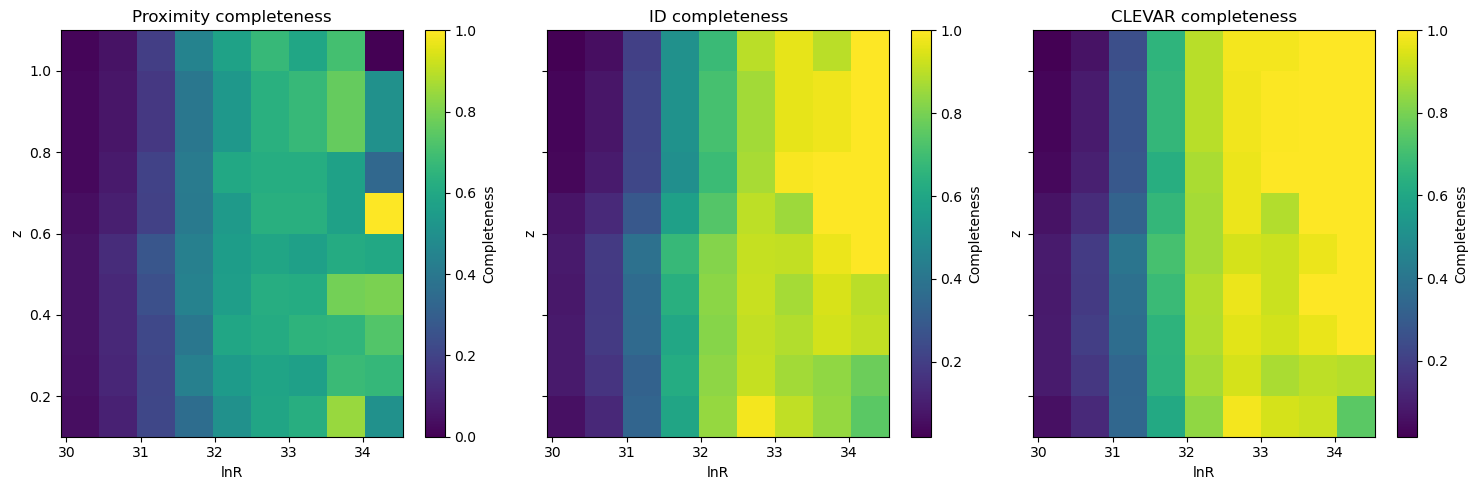

In [3]:
lnM_bins_knots = np.linspace(np.log(10**logMmin), np.log(10**logMmax) ,10)
z_bins_knots = np.array([0.1 , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])

lnM = np.log(data_dc2['halo_mass'])
z   = data_dc2['redshift_true']


proximity = np.isin(data_dc2['halo_id'], proximity_data['halo_id'])
ids       = np.isin(data_dc2['halo_id'], id_data['halo_id'])
clevar    = np.isin(data_dc2['halo_id'], clusters_clevar['mt_cross'])

# ---- INPUT ARRAYS ----
# lnR, z: shape (N,)
# detected: boolean, shape (N,)
# lnR_bins_knots, z_bins_knots: 1D arrays (edges)

# ---- BINNING ----
nR = len(lnM_bins_knots) - 1
nz = len(z_bins_knots) - 1

# 2D histogram for total and detected counts
H_total, _, _ = np.histogram2d(lnM, z, bins=[lnM_bins_knots, z_bins_knots])
H_proximity, _, _ = np.histogram2d(lnM[proximity], z[proximity], bins=[lnM_bins_knots, z_bins_knots])
H_id, _, _ = np.histogram2d(lnM[ids], z[ids], bins=[lnM_bins_knots, z_bins_knots])
H_clevar, _, _ = np.histogram2d(lnM[clevar], z[clevar], bins=[lnM_bins_knots, z_bins_knots])

# Compute completeness (observed / total)
with np.errstate(invalid='ignore', divide='ignore'):
    c_proximity = H_proximity / H_total
    c_proximity[H_total == 0] = np.nan  # undefined in empty bins

    c_id = H_id / H_total
    c_id[H_total == 0] = np.nan  # undefined in empty bins

    c_clevar = H_clevar / H_total
    c_clevar[H_total == 0] = np.nan  # undefined in empty bins

# ---- BIN CENTERS ----
lnM_centers = 0.5 * (lnM_bins_knots[:-1] + lnM_bins_knots[1:])
z_centers = 0.5 * (z_bins_knots[:-1] + z_bins_knots[1:])
M, Z = np.meshgrid(lnM_centers, z_centers, indexing='ij')


# ---- PLOTTING ----
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# 1. Raw purity
pc0 = axes[0].pcolormesh(lnM_bins_knots, z_bins_knots, c_proximity.T, cmap='viridis', shading='auto')
axes[0].set_title('Proximity completeness')
fig.colorbar(pc0, ax=axes[0], label='Completeness')

# 2. Smoothed purity
pc1 = axes[1].pcolormesh(lnM_bins_knots, z_bins_knots, c_id.T, cmap='viridis', shading='auto')
axes[1].set_title('ID completeness')
fig.colorbar(pc1, ax=axes[1], label='Completeness')

# 3. Difference
pc2 = axes[2].pcolormesh(lnM_bins_knots, z_bins_knots, c_clevar.T, cmap='viridis', shading='auto')
axes[2].set_title('CLEVAR completeness')
fig.colorbar(pc2, ax=axes[2], label='Completeness')

for ax in axes:
    ax.set_xlabel('lnR')
    ax.set_ylabel('z')

plt.tight_layout()
plt.show()

### Smoothed completeness

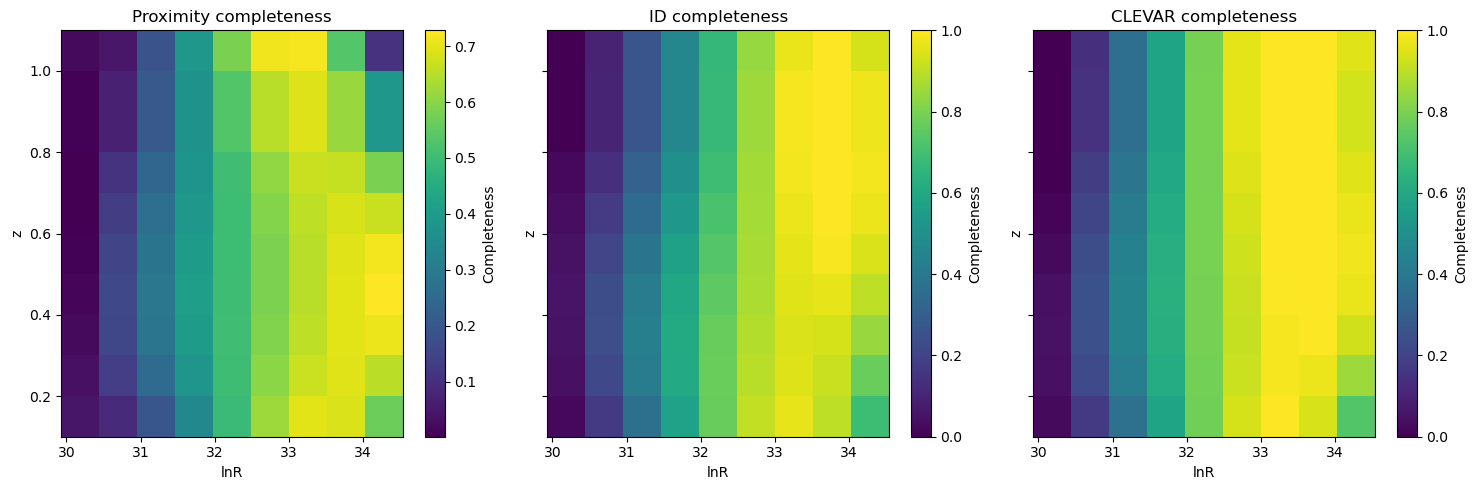

In [4]:
# ---- SPLINE FITTING ----
# Fit only on bins with valid data
mask_proximity = ~np.isnan(c_proximity)
mask_id = ~np.isnan(c_id)
mask_clevar = ~np.isnan(c_clevar)

# Choose internal knots (exclude boundaries)
tx = lnM_centers[1:-1]
ty = z_centers[1:-1]

#spline = LSQBivariateSpline(x_fit, y_fit, z_fit, tx, ty,eps=0.99)
spline_proximity = SmoothBivariateSpline(M[mask_proximity].ravel(), Z[mask_proximity].ravel(), c_proximity[mask_proximity].ravel())
spline_id = SmoothBivariateSpline(M[mask_id].ravel(), Z[mask_id].ravel(), c_id[mask_id].ravel())
spline_clevar = SmoothBivariateSpline(M[mask_clevar].ravel(), Z[mask_clevar].ravel(), c_clevar[mask_clevar].ravel())
# Evaluate on full grid
c_proximity_smooth = spline_proximity(lnM_centers, z_centers)
c_id_smooth = spline_id(lnM_centers, z_centers)
c_clevar_smooth = spline_clevar(lnM_centers, z_centers)

c_proximity_smooth_clipped = np.clip(c_proximity_smooth, 0.0, 1.0)
c_id_smooth_clipped = np.clip(c_id_smooth, 0.0, 1.0)
c_clevar_smooth_clipped = np.clip(c_clevar_smooth, 0.0, 1.0)


c_proximity_knots = Ncm.Matrix.new(len(z_centers),len(lnM_centers))
c_id_knots = Ncm.Matrix.new(len(z_centers),len(lnM_centers))
c_clevar_knots = Ncm.Matrix.new(len(z_centers),len(lnM_centers))
for i in range(len(z_centers)):
    for j in range(len(lnM_centers)):
        c_proximity_knots.set(i,j, c_proximity_smooth_clipped.T[i][j])
        c_id_knots.set(i,j, c_id_smooth_clipped.T[i][j])
        c_clevar_knots.set(i,j, c_clevar_smooth_clipped.T[i][j])

#Creating the splines
c_proximity_spline = Ncm.Spline2dBicubic(spline=Ncm.SplineCubicNotaknot.new(),x_vector=Ncm.Vector.new_array(npa_to_seq(lnM_centers)),
y_vector=Ncm.Vector.new_array(npa_to_seq(z_centers)),
z_matrix=c_proximity_knots
)
c_proximity_spline.prepare()
c_proximity = np.array([[c_proximity_spline.eval(lnM_centers[i],z_centers[j]) for j in range(len(z_centers))] for i in range(len(lnM_centers))])


c_id_spline = Ncm.Spline2dBicubic(spline=Ncm.SplineCubicNotaknot.new(),x_vector=Ncm.Vector.new_array(npa_to_seq(lnM_centers)),
y_vector=Ncm.Vector.new_array(npa_to_seq(z_centers)),
z_matrix=c_id_knots
)
c_id_spline.prepare()
c_id = np.array([[c_id_spline.eval(lnM_centers[i],z_centers[j]) for j in range(len(z_centers))] for i in range(len(lnM_centers))])

c_clevar_spline = Ncm.Spline2dBicubic(spline=Ncm.SplineCubicNotaknot.new(),x_vector=Ncm.Vector.new_array(npa_to_seq(lnM_centers)),
y_vector=Ncm.Vector.new_array(npa_to_seq(z_centers)),
z_matrix=c_clevar_knots
)
c_clevar_spline.prepare()
c_clevar = np.array([[c_clevar_spline.eval(lnM_centers[i],z_centers[j]) for j in range(len(z_centers))] for i in range(len(lnM_centers))])



# ---- PLOTTING ----
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# 1. Raw purity
pc0 = axes[0].pcolormesh(lnM_bins_knots, z_bins_knots, c_proximity.T, cmap='viridis', shading='auto')
axes[0].set_title('Proximity completeness')
fig.colorbar(pc0, ax=axes[0], label='Completeness')

# 2. Smoothed purity
pc1 = axes[1].pcolormesh(lnM_bins_knots, z_bins_knots, c_id.T, cmap='viridis', shading='auto')
axes[1].set_title('ID completeness')
fig.colorbar(pc1, ax=axes[1], label='Completeness')

# 3. Difference
pc2 = axes[2].pcolormesh(lnM_bins_knots, z_bins_knots, c_clevar.T, cmap='viridis', shading='auto')
axes[2].set_title('CLEVAR completeness')
fig.colorbar(pc2, ax=axes[2], label='Completeness')

for ax in axes:
    ax.set_xlabel('lnR')
    ax.set_ylabel('z')

plt.tight_layout()
plt.show()

## Purity

### Raw purity

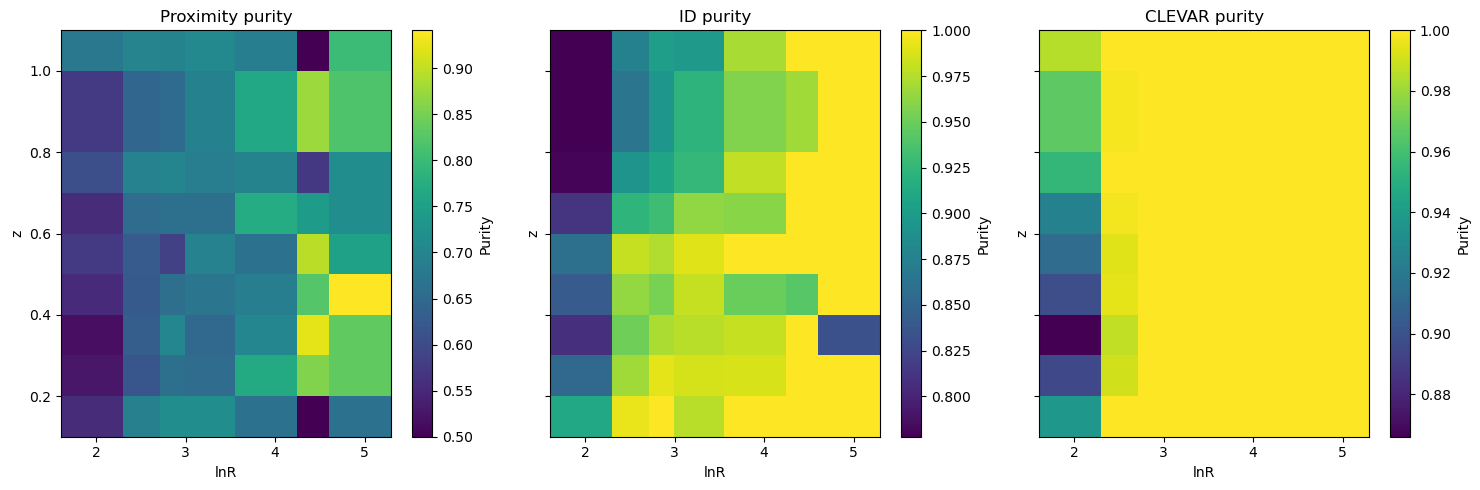

In [5]:
lnR_bins_knots = np.log(np.array([5, 10, 15, 20, 35, 70, 100, 200]))
z_bins_knots = np.array([0.1 , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])

lnR = np.log(data_redmapper['richness'])
z   = data_redmapper['redshift']


proximity = np.isin(data_redmapper['cluster_id'], proximity_data['cluster_id'])
ids       = np.isin(data_redmapper['cluster_id'], id_data['cluster_id'])
clevar    = np.isin(data_redmapper['cluster_id'], halos_clevar['mt_cross'])
# ---- INPUT ARRAYS ----
# lnR, z: shape (N,)
# detected: boolean, shape (N,)
# lnR_bins_knots, z_bins_knots: 1D arrays (edges)

# ---- BINNING ----
nR = len(lnR_bins_knots) - 1
nz = len(z_bins_knots) - 1

# 2D histogram for total and detected counts
H_total, _, _ = np.histogram2d(lnR, z, bins=[lnR_bins_knots, z_bins_knots])
H_proximity, _, _ = np.histogram2d(lnR[proximity], z[proximity], bins=[lnR_bins_knots, z_bins_knots])
H_id, _, _ = np.histogram2d(lnR[ids], z[ids], bins=[lnR_bins_knots, z_bins_knots])
H_clevar, _, _ = np.histogram2d(lnR[clevar], z[clevar], bins=[lnR_bins_knots, z_bins_knots])

# Compute Purity (observed / total)
with np.errstate(invalid='ignore', divide='ignore'):
    p_proximity = H_proximity / H_total
    p_proximity[H_total == 0] = np.nan  # undefined in empty bins

    p_id = H_id / H_total
    p_id[H_total == 0] = np.nan  # undefined in empty bins

    p_clevar= H_clevar / H_total
    p_clevar[H_total == 0] = np.nan  # undefined in empty bins

# ---- BIN CENTERS ----
lnR_centers = 0.5 * (lnR_bins_knots[:-1] + lnR_bins_knots[1:])
z_centers = 0.5 * (z_bins_knots[:-1] + z_bins_knots[1:])
R, Z = np.meshgrid(lnR_centers, z_centers, indexing='ij')


# ---- PLOTTING ----
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# 1. Raw purity
pc0 = axes[0].pcolormesh(lnR_bins_knots, z_bins_knots, p_proximity.T, cmap='viridis', shading='auto')
axes[0].set_title('Proximity purity')
fig.colorbar(pc0, ax=axes[0], label='Purity')

# 2. Smoothed purity
pc1 = axes[1].pcolormesh(lnR_bins_knots, z_bins_knots, p_id.T, cmap='viridis', shading='auto')
axes[1].set_title('ID purity')
fig.colorbar(pc1, ax=axes[1], label='Purity')

# 3. Difference
pc2 = axes[2].pcolormesh(lnR_bins_knots, z_bins_knots, p_clevar.T, cmap='viridis', shading='auto')
axes[2].set_title('CLEVAR purity')
fig.colorbar(pc2, ax=axes[2], label='Purity')

for ax in axes:
    ax.set_xlabel('lnR')
    ax.set_ylabel('z')

plt.tight_layout()
plt.show()

### Smoothed purity

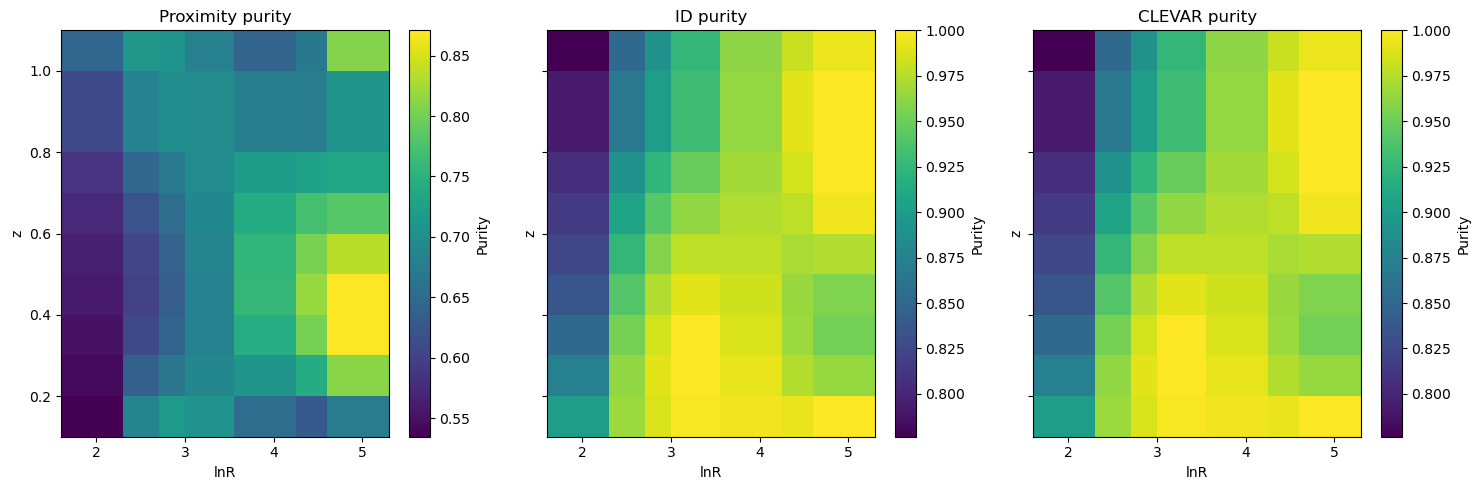

In [6]:
# ---- SPLINE FITTING ----
# Fit only on bins with valid data
mask_proximity = ~np.isnan(p_proximity)
mask_id = ~np.isnan(p_id)
mask_clevar = ~np.isnan(p_clevar)

# Choose internal knots (exclude boundaries)
tx = lnR_centers[1:-1]
ty = z_centers[1:-1]

#spline = LSQBivariateSpline(x_fit, y_fit, z_fit, tx, ty,eps=0.99)
spline_proximity = SmoothBivariateSpline(R[mask_proximity].ravel(), Z[mask_proximity].ravel(), p_proximity[mask_proximity].ravel())
spline_id = SmoothBivariateSpline(R[mask_id].ravel(), Z[mask_id].ravel(), p_id[mask_id].ravel())
spline_clevar = SmoothBivariateSpline(R[mask_clevar].ravel(), Z[mask_clevar].ravel(), p_id[mask_clevar].ravel())
# Evaluate on full grid
p_proximity_smooth = spline_proximity(lnR_centers, z_centers)
p_id_smooth = spline_id(lnR_centers, z_centers)
p_clevar_smooth = spline_clevar(lnR_centers, z_centers)

p_proximity_smooth_clipped = np.clip(p_proximity_smooth, 0.0, 1.0)
p_id_smooth_clipped = np.clip(p_id_smooth, 0.0, 1.0)
p_clevar_smooth_clipped = np.clip(p_clevar_smooth, 0.0, 1.0)


p_proximity_knots = Ncm.Matrix.new(len(z_centers),len(lnR_centers))
p_id_knots = Ncm.Matrix.new(len(z_centers),len(lnR_centers))
p_clevar_knots = Ncm.Matrix.new(len(z_centers),len(lnR_centers))
for i in range(len(z_centers)):
    for j in range(len(lnR_centers)):
        p_proximity_knots.set(i,j, p_proximity_smooth_clipped.T[i][j])
        p_id_knots.set(i,j, p_id_smooth_clipped.T[i][j])
        p_clevar_knots.set(i,j, p_clevar_smooth_clipped.T[i][j])

#Creating the splines
p_proximity_spline = Ncm.Spline2dBicubic(spline=Ncm.SplineCubicNotaknot.new(),x_vector=Ncm.Vector.new_array(npa_to_seq(lnR_centers)),
y_vector=Ncm.Vector.new_array(npa_to_seq(z_centers)),
z_matrix=p_proximity_knots
)
p_proximity_spline.prepare()
p_proximity = np.array([[p_proximity_spline.eval(lnR_centers[i],z_centers[j]) for j in range(len(z_centers))] for i in range(len(lnR_centers))])


p_id_spline = Ncm.Spline2dBicubic(spline=Ncm.SplineCubicNotaknot.new(),x_vector=Ncm.Vector.new_array(npa_to_seq(lnR_centers)),
y_vector=Ncm.Vector.new_array(npa_to_seq(z_centers)),
z_matrix=p_id_knots
)
p_id_spline.prepare()
p_id = np.array([[p_id_spline.eval(lnR_centers[i],z_centers[j]) for j in range(len(z_centers))] for i in range(len(lnR_centers))])


p_clevar_spline = Ncm.Spline2dBicubic(spline=Ncm.SplineCubicNotaknot.new(),x_vector=Ncm.Vector.new_array(npa_to_seq(lnR_centers)),
y_vector=Ncm.Vector.new_array(npa_to_seq(z_centers)),
z_matrix=p_clevar_knots
)
p_clevar_spline.prepare()
p_clevar = np.array([[p_clevar_spline.eval(lnR_centers[i],z_centers[j]) for j in range(len(z_centers))] for i in range(len(lnR_centers))])



# ---- PLOTTING ----
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# 1. Raw purity
pc0 = axes[0].pcolormesh(lnR_bins_knots, z_bins_knots, p_proximity.T, cmap='viridis', shading='auto')
axes[0].set_title('Proximity purity')
fig.colorbar(pc0, ax=axes[0], label='Purity')

# 2. Smoothed purity
pc1 = axes[1].pcolormesh(lnR_bins_knots, z_bins_knots, p_id.T, cmap='viridis', shading='auto')
axes[1].set_title('ID purity')
fig.colorbar(pc1, ax=axes[1], label='Purity')

# 3. Difference
pc2 = axes[2].pcolormesh(lnR_bins_knots, z_bins_knots, p_clevar.T, cmap='viridis', shading='auto')
axes[2].set_title('CLEVAR purity')
fig.colorbar(pc2, ax=axes[2], label='Purity')

for ax in axes:
    ax.set_xlabel('lnR')
    ax.set_ylabel('z')

plt.tight_layout()
plt.show()